In [1]:
from drn_interactions.load import load_neurons_derived, load_derived_generic
from drn_interactions.spikes import SpikesHandler
from drn_interactions.brain_state_decode import StateDecoder, StateDecodeDataLoader, StateDecodePreprocessor

from sklearn.model_selection import  KFold
from sklearn.ensemble import RandomForestClassifier
from drn_interactions.brain_state_decode import shuffle_X, PreprocessingError
from drn_interactions.decoding_plots import (
    pop_unit_hist,
    compare_best_unit,
    plot_performance_vs_n_units,
    dropout_boxplots
    )
from drn_interactions.stats import mannwhitneyu_plusplus
from scipy.stats import wilcoxon
from IPython.display import display

from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
import pandas as pd
sns.set_theme(context="poster", style="ticks")

from IPython.display import display

%load_ext autoreload
%autoreload 2

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [34]:
def eeg_decode(
    loader: StateDecodeDataLoader,
    preprocessor:StateDecodePreprocessor,
    decoder: StateDecoder,
    nboot = 75,
    fit_unit_models: bool = True,
    ):
    spikes, states = loader()
    try:
        spikes, states = preprocessor(spikes, states)
    except PreprocessingError as e:
        raise e
    
    pop_true = np.mean(decoder.get_real_scores(spikes, states))
    out_pop = pd.DataFrame({"true": pop_true}, index=[0]) 
    
    if nboot is not None:
        pop_reps = decoder.get_bootstrap_scores(spikes, states, n_boot=nboot)
        pop_shuffle = np.mean(pop_reps, axis=1).mean()
        out_pop["shuffle"] = pop_shuffle
    
    if fit_unit_models:
        unit_scores = decoder.get_unit_scores(spikes, states)
        out_unit = pd.DataFrame(unit_scores).mean().to_frame("F1 Score").reset_index().rename(columns=dict(index="neuron_id"))
    else: 
        out_unit = None
    return out_pop, out_unit

def eeg_decode_multi(sessions, loader, preprocessor, decoder, nboot=75, fit_unit_models: bool = True, verbose=False):
    pop_df_list = []
    unit_df_list = []
    for session in sessions:
        if verbose:
            print(session) 
        loader_session = deepcopy(loader)
        loader_session.set_session(session)
        try:
            pop, unit = eeg_decode(loader_session, preprocessor, decoder, nboot, fit_unit_models=fit_unit_models)
        except PreprocessingError as e:
            if verbose:
                print(f"{session}: {str(e)}")
            continue
        if pop is not None:
            pop = pop.assign(session_name=session) 
        if unit is not None:
            unit = unit.assign(session_name=session)
        pop_df_list.append(pop)
        unit_df_list.append(unit)
    out_pop = pd.concat(pop_df_list).reset_index(drop=True)
    if fit_unit_models:
        out_unit = pd.concat(unit_df_list).reset_index(drop=True)
    else:
        out_unit = None
    return out_pop, out_unit

## Load Data

In [10]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
neurons = load_neurons_derived()
sessions = neurons.merge(eeg_states[["session_name"]].drop_duplicates(), on="session_name")["session_name"].unique()

## Run Decoding Models

In [90]:
# default settings

loader =StateDecodeDataLoader(
    session_name=None,
    block="pre",
    t_start=0,
    t_stop=1800,
    bin_width=1,
    )
preprocessor = StateDecodePreprocessor(thresh_empty=2)
pipe = RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1)
cv = KFold(shuffle=True)
decoder = StateDecoder(
    estimator=pipe,
    cv=cv,
    shuffler=shuffle_X
)

#### Individual Units and Entire Population

In [91]:
pop_all, unit_all = eeg_decode_multi(sessions, loader, preprocessor, decoder, nboot=1)

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


#### Limit Number of Units

In [41]:
# limit n units
from drn_interactions.brain_state_decode import PreprocessingError

pops = []
for i in range(1, 31):
    print(f"Units: {i}")
    preprocessor = StateDecodePreprocessor(thresh_empty=2, exact_units=i)
    pop_sub, _ = eeg_decode_multi(
        sessions,
        loader,
        preprocessor,
        decoder,
        nboot=None,
        fit_unit_models=False,
        verbose=False,
    )
    pops.append(pop_sub.assign(n_units=i))

df_pop_n = pd.concat(pops)

Units: 1
Units: 2
Units: 3
Units: 4
Units: 5
Units: 6
Not enough units
Units: 7
Not enough units
Units: 8
Not enough units
Units: 9
Not enough units
Not enough units
Units: 10
Not enough units
Not enough units
Not enough units
Units: 11
Not enough units
Not enough units
Not enough units
Units: 12
Not enough units
Not enough units
Not enough units
Units: 13
Not enough units
Not enough units
Not enough units
Not enough units
Units: 14
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Units: 15
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Units: 16
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Units: 17
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Units: 18
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Not enough units
Units: 19
Not enough units
Not

In [61]:
# limit neuron type
from drn_interactions.brain_state_decode import PreprocessingError

pops_nts = []
neuron_types = ["sr", "sir", "ff"]

for neuron_type in neuron_types:
    print(f"Neuron Type: {neuron_type}")
    ntypes_sub = deepcopy(neuron_types)
    ntypes_sub.remove(neuron_type)
    preprocessor = StateDecodePreprocessor(thresh_empty=2, neuron_types=ntypes_sub)
    pop_sub, _ = eeg_decode_multi(
        sessions,
        loader,
        preprocessor,
        decoder,
        nboot=None,
        fit_unit_models=False,
        verbose=False,
    )
    pops_nts.append(pop_sub.assign(dropout=neuron_type))

df_pop_nt = pd.concat(pops_nts)

Neuron Type: sr
Neuron Type: sir
Neuron Type: ff


In [229]:
# save results
from drn_interactions.load import get_derived_data_dir

out_dir = get_derived_data_dir() / "decoding" / "brain state"
out_dir.mkdir(parents=True, exist_ok=True)

pop_all.to_csv(out_dir / "decoding - brain state - all population (and shuffle).csv", index=False)
unit_all.to_csv(out_dir / "decoding - brain state - single units.csv", index=False)
df_pop_n.to_csv(out_dir / "decoding - brain state - limited unit population.csv", index=False)
df_pop_nt.to_csv(out_dir / "decoding - brain state - neuron type dropout.csv", index=False)

## Plots

<AxesSubplot:xlabel='Neuron Type Dropped Out', ylabel='F1 Score'>

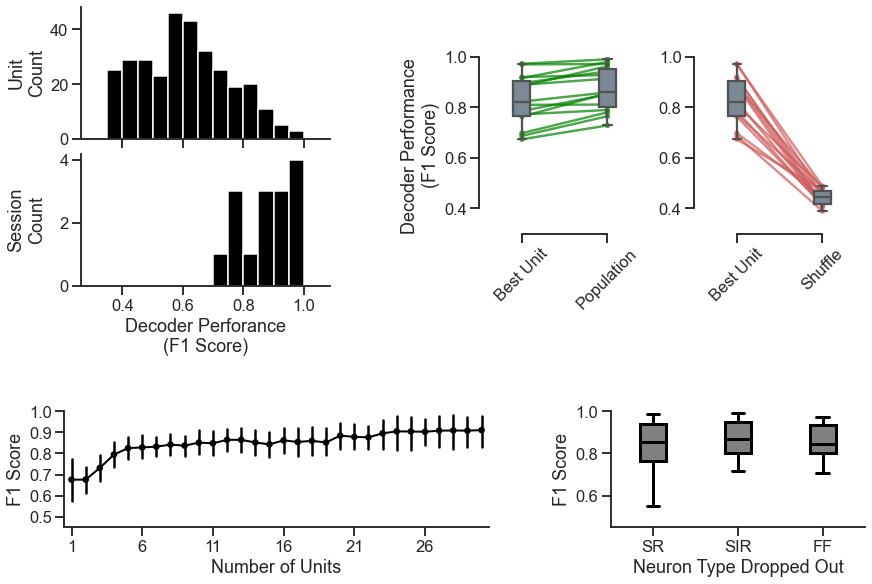

In [228]:
# best unit v pop, then best unit v shuffle
sns.set_theme(context="talk", style="ticks")
f = plt.figure(figsize=(12, 8), constrained_layout=True)

(f_top, f_bottom) = f.subfigures(2, 1, height_ratios=[1, 0.5], hspace=0.15)

#### top figure
f_hist, f_box = f_top.subfigures(1, 2, width_ratios=[0.35, 0.5], wspace=0.15)

# hists
(ax_unit, ax_pop) = f_hist.subplots(2, 1, sharex=True)
pop_unit_hist(pop_all, unit_all, ax_pop=ax_pop, ax_unit=ax_unit)
f_hist.align_ylabels()


# boxes
gs_box = f_box.add_gridspec(
    3, 2, width_ratios=[0.5, 0.5], height_ratios=[0.15, 0.6, 0.15]
    )

ax_true = f_box.add_subplot(gs_box[1, 0])
ax_shuffle = f_box.add_subplot(gs_box[1, 1])
kwargs = dict(pointplot_kwargs={"alpha": 0.7}, boxplot_in_front=True,)
df_pop_all_long = pop_all.melt(
    id_vars="session_name", 
    var_name="shuffle_status", 
    value_name="F1 Score"
    )
compare_best_unit(unit_all, df_pop_long=df_pop_all_long.query("shuffle_status == 'true'"), ylim=(0.3, 1), ax=ax_true, **kwargs)
compare_best_unit(unit_all, df_pop_long=df_pop_all_long.query("shuffle_status == 'shuffle'"), ylim=(0.3, 1), ax=ax_shuffle, **kwargs)
ax_shuffle.set_xticklabels(["Best Unit", "Shuffle"], rotation=45)
ax_true.set_xticklabels(["Best Unit", "Population"], rotation=45)
ax_shuffle.set_ylabel("")

### Bottom Figure
# line over time
gs = f_bottom.add_gridspec(nrows=1, ncols=2, width_ratios=[0.5, 0.3], wspace=0.15)

ax_line = f_bottom.add_subplot(gs[0, 0])
plot_performance_vs_n_units(df_pop_n, ax=ax_line)
sns.despine(ax=ax_line)

ax_box = f_bottom.add_subplot(gs[0, 1])
dropout_boxplots(df_pop_nt, ax=ax_box)


## Statistics

In [253]:


# all units to population (and shuffle)
res_pop = mannwhitneyu_plusplus(
    x=unit_all["F1 Score"], 
    y=pop_all["true"], 
    names=("Individual Units", "Population"), 
    ).to_frame(name="pop")

res_shuffle = mannwhitneyu_plusplus(
    x=unit_all["F1 Score"], 
    y=pop_all["shuffle"], 
    names=("Individual Units", "Population"), 
    ).to_frame(name="shuffle")

res_all = res_pop.join(res_shuffle).transpose()
display(res_all.round(3))

,n_Individual Units,n_Population,Mean_Individual Units,Mean_Population,Diff,U,p
pop,310.0,15.0,0.609,0.876,0.267,307.0,0.0
shuffle,310.0,15.0,0.609,0.440,-0.168,3882.0,0.0


In [268]:
# compare best unit to population and shuffle
best_unit_pop = (
        unit_all.merge(neurons)
        .groupby("session_name")["F1 Score"]
        .max()
        .to_frame("Best Unit")
        .reset_index()
        .merge(pop_all[["session_name", "true", "shuffle"]])
    )

res_pop = mannwhitneyu_plusplus(
    x=best_unit_pop["Best Unit"], 
    y=best_unit_pop["true"], 
    names=("Best Unit", "Population"), 
    compare_f=wilcoxon,
    ).to_frame(name="pop")

res_shuffle = mannwhitneyu_plusplus(
    x=best_unit_pop["Best Unit"], 
    y=best_unit_pop["shuffle"], 
    names=("Best Unit", "Population"), 
    compare_f=wilcoxon,
    ).to_frame(name="shuff")

best_unit_res = res_pop.join(res_shuffle).transpose()
display(best_unit_res.round(3).rename(columns={"U": "W"}))

,n_Best Unit,n_Population,Mean_Best Unit,Mean_Population,Diff,W,p
pop,15.0,15.0,0.831,0.876,0.045,0.0,0.0
shuff,15.0,15.0,0.831,0.440,-0.390,0.0,0.0


In [269]:
# performance v dropout

dropout_res = pg.anova(data=df_pop_nt, dv="true", between="dropout")
display(dropout_res.round(3))

,Source,ddof1,ddof2,F,p-unc,np2
0,dropout,2,42,0.299,0.743,0.014
